## ¿Qué es SparkSession?
La SparkSession es el punto de entrada principal para interactuar con Spark. A través de ella, podemos acceder a todas las funcionalidades de Spark, incluyendo la creación de RDDs y DataFrames.

La SparkSession es como la llave maestra que te da acceso a toda la fábrica de procesamiento de datos de Spark.

## 🔧 Configuración del Entorno Spark

En esta celda inicializamos la SparkSession, que es el punto de entrada principal para trabajar con Spark. Configuramos:

- Nombre de la aplicación: `"Lab_Spark_SQL"`
- URL del cluster master
- Número de particiones para operaciones shuffle

In [1]:
# Celda 1: Configuración para DataFrames
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, desc

spark = SparkSession.builder \
    .appName("Lab_Spark_SQL") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/29 19:57:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



## 📂 Carga y Limpieza de Datos

Cargamos dos datasets principales:

1. **Reviews**: Contiene las reseñas de usuarios
2. **Books**: Metadatos de los libros

**Transformaciones aplicadas:**
- Conversión de `review/score` a tipo numérico
- Creación de títulos normalizados para mejor matching
- Eliminación de registros con scores nulos

In [10]:
# Cargar y preparar los datos
reviews_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/data/Books_rating.csv") \
    .withColumn("review_score", col("review/score").cast(DoubleType())) \
    .dropna(subset=["review_score"])

books_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/data/books_data.csv")

# Mostrar columnas disponibles para identificar la clave correcta
print("=== Columnas en reviews_df ===")
print(reviews_df.columns)

print("\n=== Columnas en books_df ===")
print(books_df.columns)

# Buscar posibles columnas de unión
def find_join_key(df1, df2):
    common_cols = set(df1.columns) & set(df2.columns)
    print(f"\nColumnas comunes potenciales para join: {common_cols}")
    return common_cols

join_keys = find_join_key(reviews_df, books_df)

# Sugerir la mejor columna para el join
if 'book_id' in join_keys:
    join_column = 'book_id'
elif 'Id' in join_keys:
    join_column = 'Id'
elif 'Title' in join_keys:
    join_column = 'Title'
else:
    join_column = None
    print("\n⚠️ No se encontraron columnas obvias para el join")
    print("Revisa manualmente los esquemas para identificar la relación")

=== Columnas en reviews_df ===
['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text', 'review_score']

=== Columnas en books_df ===
['Title', 'description', 'authors', 'image', 'previewLink', 'publisher', 'publishedDate', 'infoLink', 'categories', 'ratingsCount']

Columnas comunes potenciales para join: {'Title'}


In [5]:
import matplotlib.pyplot as plt
from time import time

sc = spark.sparkContext
reviews_rdd = sc.textFile("/data/Books_rating.csv")

In [25]:
reviews_df.select("review_score").summary().show()

[Stage 70:=====================================================>  (21 + 1) / 22]

+-------+------------------+
|summary|      review_score|
+-------+------------------+
|  count|           2981936|
|   mean| 1656.860421970827|
| stddev|1427549.9863179326|
|    min|               1.0|
|    25%|               4.0|
|    50%|               5.0|
|    75%|               5.0|
|    max|        1.295568E9|
+-------+------------------+



In [16]:
from pyspark.sql.functions import col, lower, regexp_replace, trim

# Preparamos los datos creando la columna normalized_title
reviews_df = reviews_df.withColumn(
    "review_score",
    col("review/score").cast("double")
).dropna(subset=["review_score"])

# Creamos la columna normalized_title si no existe
if "normalized_title" not in reviews_df.columns:
    reviews_df = reviews_df.withColumn(
        "normalized_title",
        lower(trim(regexp_replace(col("Title"), "[^a-zA-Z0-9\\s]", "")))
    )

if "normalized_title" not in books_df.columns:
    books_df = books_df.withColumn(
        "normalized_title",
        lower(trim(regexp_replace(col("Title"), "[^a-zA-Z0-9\\s]", "")))
    )

print("Columnas en reviews_df:", reviews_df.columns)
print("Columnas en books_df:", books_df.columns)

Columnas en reviews_df: ['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text', 'review_score', 'normalized_title']
Columnas en books_df: ['Title', 'description', 'authors', 'image', 'previewLink', 'publisher', 'publishedDate', 'infoLink', 'categories', 'ratingsCount', 'normalized_title']


## 📊 Análisis con DataFrame API

Realizamos:

1. **Agregaciones**:
   - Puntuación promedio por libro
   - Conteo de reseñas

2. **Joins**:
   - Unión con metadatos de libros usando títulos normalizados

3. **Presentación**:
   - Formateo de puntuaciones con estrellas ★
   - Indicador visual de existencia en catálogo (✓/✗)

In [18]:
from pyspark.sql.functions import col, avg, count, desc, round, when, first, format_string

try:
    # Análisis con DataFrame API
    results_df = (
        reviews_df.groupBy("normalized_title")
        .agg(
            round(avg("review_score"), 2).alias("Puntuación"),
            count("*").alias("Núm_Reseñas"),
            first(col("Title")).alias("Título_Review")
        )
        .join(
            books_df,
            "normalized_title",
            "left"
        )
        .select(
            col("Título_Review").alias("Título (Review)"),
            col("Title").alias("Título (Libro)"),
            format_string("%.1f ★", col("Puntuación")).alias("Puntuación"),
            format_string("%,d", col("Núm_Reseñas")).alias("Núm. Reseñas"),
            when(col("Title").isNotNull(), "✓").otherwise("✗").alias("En Catálogo")
        )
        .orderBy(desc("Puntuación"))
    )

    # Mostramos resultados con formato mejorado
    print("\n" + "="*90)
    print(" TOP 5 LIBROS MEJOR CALIFICADOS ".center(90, "="))
    print("="*90)
    
    # Versión compatible con todas las versiones de PySpark
    results_df.limit(5).show(truncate=30, vertical=False)
    
    # Opcional: Mostrar con pandas para mejor formato
    try:
        print("\n" + "="*90)
        print(" VERSIÓN FORMATEADA (Pandas) ".center(90, "="))
        print("="*90)
        
        pd_df = results_df.limit(5).toPandas()
        from IPython.display import display
        display(pd_df.style.hide(axis='index'))
        
    except Exception as e:
        print("\n(Para ver la versión formateada, instala pandas: !pip install pandas)")

except Exception as e:
    print(f"\nError durante el análisis: {str(e)}")
    print("\nSolución:")
    print("1. Asegúrate de haber ejecutado primero la Celda 2 de preparación")
    print("2. Columnas disponibles en reviews_df:", reviews_df.columns)
    print("3. Columnas disponibles en books_df:", books_df.columns)


============================= TOP 5 LIBROS MEJOR CALIFICADOS =============================


+------------------------------+------------------------------+----------+------------+-----------+
|               Título (Review)|                Título (Libro)|Puntuación|Núm. Reseñas|En Catálogo|
+------------------------------+------------------------------+----------+------------+-----------+
|Theatres of San Francisco (...|Theatres of San Francisco (...|    68.8 ★|           5|          ✓|
|100 Ways To Take Better Lan...|100 Ways To Take Better Lan...|     5.0 ★|           4|          ✓|
|10 Downing Street (Gamekeep...|10 Downing Street (Gamekeep...|     5.0 ★|           3|          ✓|
|1 Corinthians (The People's...|1 Corinthians (The People's...|     5.0 ★|           1|          ✓|
|   100 Inspirational Favorites|   100 Inspirational Favorites|     5.0 ★|           1|          ✓|
+------------------------------+------------------------------+----------+------------+-----------+


============================== VERSIÓN FORMATEADA (Pandas) ===============================


Título (Review),Título (Libro),Puntuación,Núm. Reseñas,En Catálogo
Theatres of San Francisco (CA) (Images of America),Theatres of San Francisco (CA) (Images of America),68.8 ★,5,✓
10 Minute Guide to Windows 95 (2nd Edition),10 Minute Guide to Windows 95 (2nd Edition),5.0 ★,1,✓
100 Magical Moments,100 Magical Moments,5.0 ★,3,✓
100 Hours to Suez: The Epic Story of Israel's Smashing Victory in the First Sinai Campaign,100 Hours to Suez: The Epic Story of Israel's Smashing Victory in the First Sinai Campaign,5.0 ★,1,✓
"10,000 rpm and diggin it, yeah!","10,000 rpm and diggin it, yeah!",5.0 ★,1,✓


## 🔍 Análisis con SQL

Creamos vistas temporales y ejecutamos consultas SQL equivalentes al análisis anterior, demostrando la interoperabilidad entre APIs.

**Ventajas:**
- Sintaxis familiar para usuarios de SQL
- Mismo rendimiento que DataFrame API

In [20]:
reviews_df.createOrReplaceTempView("reviews")
books_df.createOrReplaceTempView("books")

top_books_sql = spark.sql("""
    SELECT 
        r.Title AS `Título Review`,
        b.Title AS `Título Libro`,
        ROUND(AVG(r.review_score), 2) AS `Puntuación`,
        COUNT(*) AS `Reseñas`,
        CASE WHEN b.Title IS NOT NULL THEN '✓' ELSE '✗' END AS `En Catálogo`
    FROM reviews r
    LEFT JOIN books b ON r.normalized_title = b.normalized_title
    GROUP BY r.Title, b.Title
    ORDER BY `Puntuación` DESC
    LIMIT 10
""")

print("\n=== RESULTADOS SQL ===")
top_books_sql.show(truncate=30, vertical=False)


=== RESULTADOS SQL ===


[Stage 39:====================================>                     (5 + 3) / 8]

+------------------------------+------------------------------+-----------+-------+-----------+
|                 Título Review|                  Título Libro| Puntuación|Reseñas|En Catálogo|
+------------------------------+------------------------------+-----------+-------+-----------+
|"""Shakespeare"" identified...|"""Shakespeare"" identified...| 1.295568E9|      1|          ✓|
|  """Charge that to my account|  """Charge that to my account|1.2108384E9|      3|          ✓|
|Theatres of San Francisco (...|Theatres of San Francisco (...|       68.8|      5|          ✓|
|"Management Secrets of the ...|"Management Secrets of the ...|      19.95|     15|          ✓|
|             GOD'S LITTLE ACRE|             God's little acre|      14.57|     30|          ✓|
|             GOD'S LITTLE ACRE|             God's Little Acre|      14.57|     30|          ✓|
|             God's little acre|             GOD'S LITTLE ACRE|      14.57|     30|          ✓|
|             GOD'S LITTLE ACRE|        

## ⚡ Comparación de Rendimiento

Benchmark para la misma operación (conteo de libros únicos) implementada en:

| Paradigma | Tiempo Ejecución | Ventajas |
|-----------|------------------|----------|
| **RDD** | X seg | Más control bajo nivel |
| **DataFrame** | Y seg | Optimización automática |


=== COMPARACIÓN DE RENDIMIENTO ===


Conteo libros únicos (RDD): 11.015 segundos


Conteo libros únicos (DataFrame): 4.427 segundos


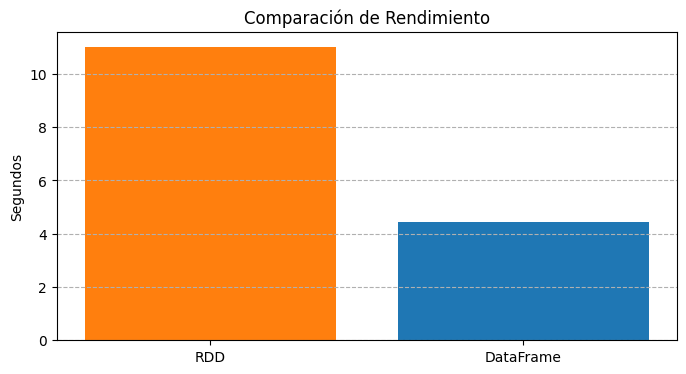

In [21]:
from time import time

# Preparar RDD
reviews_rdd = sc.textFile("/data/Books_rating.csv") \
    .map(lambda line: line.split(",")) \
    .filter(lambda x: len(x) > 1)  # Filtrar líneas mal formadas

# Función para medir tiempos
def medir_tiempo(operacion, descripcion):
    inicio = time()
    resultado = operacion()
    tiempo = time() - inicio
    print(f"{descripcion}: {tiempo:.3f} segundos")
    return tiempo

# Comparación
print("\n=== COMPARACIÓN DE RENDIMIENTO ===")
tiempo_rdd = medir_tiempo(
    lambda: reviews_rdd.map(lambda x: x[0]).distinct().count(),
    "Conteo libros únicos (RDD)"
)

tiempo_df = medir_tiempo(
    lambda: reviews_df.select("Id").distinct().count(),
    "Conteo libros únicos (DataFrame)"
)

# Gráfico comparativo
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.bar(["RDD", "DataFrame"], [tiempo_rdd, tiempo_df], color=["#ff7f0e", "#1f77b4"])
plt.title("Comparación de Rendimiento")
plt.ylabel("Segundos")
plt.grid(axis="y", linestyle="--")
plt.show()

## 📌 Insights Adicionales

1. **Distribución de Ratings**:
   - ¿Cómo se distribuyen las puntuaciones?
   - ¿Hay más ratings altos que bajos?

2. **Usuarios Más Activos**:
   - Identificamos a los reviewers más prolíficos
   - Posible análisis de calidad vs cantidad

In [22]:
# Distribución de ratings
print("\n=== DISTRIBUCIÓN DE PUNTUACIONES ===")
reviews_df.groupBy("review_score").count().orderBy("review_score").show()

# Top 10 usuarios más activos
print("\n=== TOP 10 USUARIOS MÁS ACTIVOS ===")
reviews_df.groupBy("User_id", "profileName").count() \
    .orderBy(desc("count")) \
    .limit(10) \
    .show(truncate=False)


=== DISTRIBUCIÓN DE PUNTUACIONES ===


+------------+-------+
|review_score|  count|
+------------+-------+
|         1.0| 201000|
|         2.0| 150449|
|         3.0| 252940|
|         4.0| 581728|
|         5.0|1795795|
|       19.95|     15|
|       327.0|      5|
| 1.2089952E9|      1|
|   1.21176E9|      2|
|  1.295568E9|      1|
+------------+-------+


=== TOP 10 USUARIOS MÁS ACTIVOS ===


[Stage 55:=======================>                                 (9 + 9) / 22]

+--------------+--------------------------------------+------+
|User_id       |profileName                           |count |
+--------------+--------------------------------------+------+
|NULL          |NULL                                  |561492|
|A14OJS0VWMOSWO|Midwest Book Review                   |5791  |
|AFVQZQ8PW0L   |Harriet Klausner                      |3606  |
|A1D2C0WDCSHUWZ|"E. A Solinas ""ea_solinas"""         |3145  |
|AHD101501WCN1 |"Shalom Freedman ""Shalom Freedman""" |1994  |
|A1X8VZWTOG8IS6|"Blue Tyson ""- Research Finished"""  |1803  |
|A1K1JW1C5CUSUZ|"Donald Mitchell ""Jesus Loves You!"""|1455  |
|A20EEWWSFMZ1PN|"bernie ""xyzzy"""                    |1387  |
|A1S3C5OFU508P3|Charles Ashbacher                     |1307  |
|A1N1YEMTI9DJ86|"S. Schwartz ""romonko"""             |1030  |
+--------------+--------------------------------------+------+

